In [1]:
# setups
# One-time install in a notebook cell (comment out after first run)
!pip install pandas numpy scikit-learn xgboost shap seaborn matplotlib

In [2]:
# required imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, XGBRegressor

In [3]:
# Load & peek at the data
# What to look for: do all the columns you expect show up? Are timestamps parsed correctly?
df = pd.read_csv("sample_operational_metrics.csv", parse_dates=["timestamp_utc"])
df.head()


/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_5387/3762083014.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sample_operational_metrics.csv", parse_dates=["timestamp_utc"])


,timestamp_utc,host_id,service,cpu_pct,mem_pct,disk_used_pct,error_rate,is_holiday,change_deployed_prev_1h,incident_open_in_next_2h,p1_or_p2_next_incident
0,2025-05-14 00:00:00,app-01,payments-api,52.967142,62.317104,69.665187,0.049,0,0,0,NaN
1,2025-05-14 00:05:00,app-01,payments-api,46.617357,50.005628,70.025097,0.002,0,0,0,NaN
2,2025-05-14 00:10:00,app-01,payments-api,54.476885,46.711582,69.501059,0.023,0,0,0,NaN
3,2025-05-14 00:15:00,app-01,payments-api,63.230299,54.159466,71.238636,0.001,0,0,0,NaN
4,2025-05-14 00:20:00,app-01,payments-api,45.658466,57.902765,69.937843,0.003,0,0,0,NaN


In [4]:
# --- Basic preprocessing ---
# 
# 1. Sort by time (safety first)
df = df.sort_values("timestamp_utc")

# 2. Handle obvious outliers or impossible negatives
# These values must be a percentage — they should never go below 0% or above 100%.
metric_cols = ["cpu_pct", "mem_pct", "disk_used_pct", "error_rate"]
df[metric_cols] = df[metric_cols].clip(lower=0, upper=100)

# 3. Fill tiny gaps (if any) using forward-fill
# If there’s a missing value, fill it in with the most recent known value.
df[metric_cols] = df[metric_cols].ffill()

df.head()

,timestamp_utc,host_id,service,cpu_pct,mem_pct,disk_used_pct,error_rate,is_holiday,change_deployed_prev_1h,incident_open_in_next_2h,p1_or_p2_next_incident
0,2025-05-14 00:00:00,app-01,payments-api,52.967142,62.317104,69.665187,0.049,0,0,0,NaN
1,2025-05-14 00:05:00,app-01,payments-api,46.617357,50.005628,70.025097,0.002,0,0,0,NaN
2,2025-05-14 00:10:00,app-01,payments-api,54.476885,46.711582,69.501059,0.023,0,0,0,NaN
3,2025-05-14 00:15:00,app-01,payments-api,63.230299,54.159466,71.238636,0.001,0,0,0,NaN
4,2025-05-14 00:20:00,app-01,payments-api,45.658466,57.902765,69.937843,0.003,0,0,0,NaN


In [5]:
# Feature engineering (rolling windows & lags)
# We’ll create simple rolling-mean features for CPU & memory and a “minutes since last deployment” feature.
# Start small; you can add fancier ones later.

# Rolling Window (a moving average)
# It’s like looking at a sliding window of recent history for a metric (e.g. CPU %).
# Imagine a 30-minute moving average of CPU usage:
# If current CPU is 80%, but it’s been slowly rising from 50% over the last 30 minutes… that’s a risk signal.
# What am I doing here -> df["cpu_mean_30m"] = df["cpu_pct"].rolling(6).mean()
# I am taking the last 6 rows (each = 5 min), average them, and store it.
# Same for 2 hours (24 rows at 5-minute intervals): df["cpu_mean_2h"] = df["cpu_pct"].rolling(24).mean()

# Lag-like Feature: Time since last deployment
# When something breaks, it often happens right after a code change (deployment).
# We want the model to know how long it’s been since the last change.
# This helps the model learn things like: “If we just deployed something and CPU is rising… a problem might be coming.”

# Why we need them ?????
# Without history, the model only sees what’s happening right now.
# With rolling windows and lags, it sees what has been building up over time.
# Just like weather forecasts look at past temperatures and pressure over the last few hours, 
# incident prediction needs trends — not just snapshots.

df["cpu_mean_30m"] = df["cpu_pct"].rolling(6, min_periods=1).mean()
df["cpu_mean_2h"]  = df["cpu_pct"].rolling(24, min_periods=1).mean()
df["mem_mean_30m"] = df["mem_pct"].rolling(6, min_periods=1).mean()
df["mem_mean_2h"]  = df["mem_pct"].rolling(24, min_periods=1).mean()
df["minutes_since_deploy"] = (
    df.groupby("host_id")["change_deployed_prev_1h"]
      .transform(lambda s: (~s.astype(bool)).cumsum())
)

df.head()

,timestamp_utc,host_id,service,cpu_pct,mem_pct,disk_used_pct,error_rate,is_holiday,change_deployed_prev_1h,incident_open_in_next_2h,p1_or_p2_next_incident,cpu_mean_30m,cpu_mean_2h,mem_mean_30m,mem_mean_2h,minutes_since_deploy
0,2025-05-14 00:00:00,app-01,payments-api,52.967142,62.317104,69.665187,0.049,0,0,0,NaN,52.967142,52.967142,62.317104,62.317104,1
1,2025-05-14 00:05:00,app-01,payments-api,46.617357,50.005628,70.025097,0.002,0,0,0,NaN,49.792249,49.792249,56.161366,56.161366,2
2,2025-05-14 00:10:00,app-01,payments-api,54.476885,46.711582,69.501059,0.023,0,0,0,NaN,51.353795,51.353795,53.011438,53.011438,3
3,2025-05-14 00:15:00,app-01,payments-api,63.230299,54.159466,71.238636,0.001,0,0,0,NaN,54.322921,54.322921,53.298445,53.298445,4
4,2025-05-14 00:20:00,app-01,payments-api,45.658466,57.902765,69.937843,0.003,0,0,0,NaN,52.590030,52.590030,54.219309,54.219309,5


In [6]:
# Inject fake CPU/mem/storage/P1P2 spikes BEFORE label engineering
# df.loc[10000:10500, "cpu_pct"] = 95
# df.loc[15000:15500, "mem_pct"] = 92
# df.loc[3000:3024, "disk_used_pct"] = 91
# df.loc[4000, "p1_or_p2_next_incident"] = "P1"
# df.loc[6000, "p1_or_p2_next_incident"] = "P2"

# --- Label Engineering ---
# We are building target columns (also called "labels") that say:
# Yes, we had a CPU/memory/storage spike around this time. Use this as an example to learn from.
# We are doing this for 3 time ranges:
# 2 hours, 24 hours, 7 days

# Define what a spike looks like
# If the average of a column (like CPU %) over a window (like 2 hours) is >= 90, call that a spike (1). Otherwise, no spike (0).
# Example: If cpu_pct averaged 92% over the last 2 hours -> that’s a spike -> label = 1

def create_spike_label(df, col, threshold, window):
    return (df[col].rolling(window, min_periods=window).mean() >= threshold).astype(int)


# check each of the 3 time frames:
# 2h = 24 rows (5 min × 24)
# 24h = 288 rows
# 7d = 2016 rows
for res in ["2h", "24h", "7d"]:
    window = {"2h": 24, "24h": 288, "7d": 2016}[res]

    df[f"cpu_spike_in_next_{res}"] = 0
    df[f"mem_spike_in_next_{res}"] = 0
    df[f"storage_spike_in_next_{res}"] = 0
    df[f"incident_p1p2_in_next_{res}"] = 0

    cpu_idx = df.index[create_spike_label(df, "cpu_pct", 90, window) == 1]
    mem_idx = df.index[create_spike_label(df, "mem_pct", 90, window) == 1]
    disk_idx = df.index[df["disk_used_pct"] >= 90]
    
    p1p2_idx = df.index[df["p1_or_p2_next_incident"].isin(["P1", "P2"])]
    
    # Find the indexes where spikes happen
    # All times when CPU was too hot
    # All times when memory was too full
    # All times when storage was over 90%
    # very important trick:
    # We are saying:
    # If a spike happens at time idx, mark the past window amount of time as being in a danger zone — because the spike is coming.
    # This way, we train the model to predict the future spike based on past behavior.
    
    for idx in cpu_idx:
        df.loc[max(0, idx - window):idx, f"cpu_spike_in_next_{res}"] = 1
    for idx in mem_idx:
        df.loc[max(0, idx - window):idx, f"mem_spike_in_next_{res}"] = 1
    for idx in disk_idx:
        df.loc[max(0, idx - window):idx, f"storage_spike_in_next_{res}"] = 1
    for idx in p1p2_idx:
        df.loc[max(0, idx - window):idx, f"incident_p1p2_in_next_{res}"] = 1


df.head()

,timestamp_utc,host_id,service,cpu_pct,mem_pct,disk_used_pct,error_rate,is_holiday,change_deployed_prev_1h,incident_open_in_next_2h,...,storage_spike_in_next_2h,incident_p1p2_in_next_2h,cpu_spike_in_next_24h,mem_spike_in_next_24h,storage_spike_in_next_24h,incident_p1p2_in_next_24h,cpu_spike_in_next_7d,mem_spike_in_next_7d,storage_spike_in_next_7d,incident_p1p2_in_next_7d
0,2025-05-14 00:00:00,app-01,payments-api,52.967142,62.317104,69.665187,0.049,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2025-05-14 00:05:00,app-01,payments-api,46.617357,50.005628,70.025097,0.002,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,2025-05-14 00:10:00,app-01,payments-api,54.476885,46.711582,69.501059,0.023,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2025-05-14 00:15:00,app-01,payments-api,63.230299,54.159466,71.238636,0.001,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,2025-05-14 00:20:00,app-01,payments-api,45.658466,57.902765,69.937843,0.003,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [7]:
# This will show us how many 1s and 0s we have per label.
for col in df.columns[df.columns.str.contains("in_next")]:
    print(f"{col}:", df[col].value_counts(), "\n")

incident_open_in_next_2h: incident_open_in_next_2h
0    525595
1         5
Name: count, dtype: int64 

cpu_spike_in_next_2h: cpu_spike_in_next_2h
0    525552
1        48
Name: count, dtype: int64 

mem_spike_in_next_2h: mem_spike_in_next_2h
0    525552
1        48
Name: count, dtype: int64 

storage_spike_in_next_2h: storage_spike_in_next_2h
0    430558
1     95042
Name: count, dtype: int64 

incident_p1p2_in_next_2h: incident_p1p2_in_next_2h
0    525575
1        25
Name: count, dtype: int64 

cpu_spike_in_next_24h: cpu_spike_in_next_24h
0    525600
Name: count, dtype: int64 

mem_spike_in_next_24h: mem_spike_in_next_24h
0    525600
Name: count, dtype: int64 

storage_spike_in_next_24h: storage_spike_in_next_24h
0    409235
1    116365
Name: count, dtype: int64 

incident_p1p2_in_next_24h: incident_p1p2_in_next_24h
0    525499
1       101
Name: count, dtype: int64 

cpu_spike_in_next_7d: cpu_spike_in_next_7d
0    525600
Name: count, dtype: int64 

mem_spike_in_next_7d: mem_spike_in_nex

In [8]:
# --- Common Features ---
# Basically you going to tell the model - Use these 10 things to decide if there's a risk of an incident or performance issue.
# A lot of analysis went into this section. Before adding/updating here, please check for relations and patterns

feature_cols = [
    "cpu_pct", "mem_pct", "disk_used_pct", "error_rate",
    "cpu_mean_30m", "cpu_mean_2h",
    "mem_mean_30m", "mem_mean_2h",
    "minutes_since_deploy", "is_holiday"
]

In [9]:
# --- Training & Prediction ---
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# def train_and_predict(df, label):
#     X = df[feature_cols]
#     y = df[label]

#     if y.nunique() == 1:
#         print(f"Skipping {label}: Only one class present.")
#         return None, 0.0, None

#     # Split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.2, random_state=42
#     )

#     # Model with class balancing
#     model = XGBClassifier(
#         n_estimators=100,
#         max_depth=4,
#         learning_rate=0.1,
#         eval_metric="logloss",
#         scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
#     )

#     # Train
#     model.fit(X_train, y_train)

#     # Evaluation
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:, 1]

#     print(f"\n=== {label.upper()} ===")
#     print("ROC AUC     :", round(roc_auc_score(y_test, y_proba), 3))
#     print("Precision   :", round(precision_score(y_test, y_pred), 3))
#     print("Recall      :", round(recall_score(y_test, y_pred), 3))
#     print("F1 Score    :", round(f1_score(y_test, y_pred), 3))

#     # Prediction for latest row
#     prob = model.predict_proba(df[feature_cols].iloc[-1:])[:, 1][0]

#     # SHAP explanation
#     explainer = shap.Explainer(model)
#     shap_values = explainer(df[feature_cols].iloc[-1:])

#     return model, prob, shap_values

def train_and_predict(df, label):
    print(f"Training for: {label}")
    X = df[feature_cols]
    y = df[label]
    
    print(f"Label distribution:\n{y.value_counts()}")

    if y.nunique() == 1:
        print(f"❌ Skipping {label} — only one class present.")
        return None, 0.0, None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric="logloss",
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )

    model.fit(X_train, y_train)
    print(f"✅ Trained model for {label}")

    prob = model.predict_proba(df[feature_cols].iloc[-1:])[:, 1][0]
    
    # explainer = shap.Explainer(model)
    # shap_values = explainer(df[feature_cols].iloc[-1:])

    try:
        # Use X_test as background data for SHAP explainer
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X.iloc[[-1]])
        print(f"✅ SHAP computed for {label}")
    except Exception as e:
        print(f"⚠️ SHAP failed for {label}: {e}")
        shap_values = None
        
    return model, prob, shap_values

In [10]:
# # --- Dashboard Table ---
labels = [
    "cpu_spike_in_next_2h", "cpu_spike_in_next_24h", "cpu_spike_in_next_7d",
    "mem_spike_in_next_2h", "mem_spike_in_next_24h", "mem_spike_in_next_7d",
    "storage_spike_in_next_2h", "storage_spike_in_next_24h", "storage_spike_in_next_7d",
    "incident_p1p2_in_next_2h", "incident_p1p2_in_next_24h", "incident_p1p2_in_next_7d"
]
summary = []
models = {}
shap_explanations = {}


# for label in labels:
#     model, prob, shap_values = train_and_predict(df.copy(), label)
#     if model is None:
#         continue
#     models[label] = model
#     shap_explanations[label] = shap_values
#     top_index = shap_values.values[0].argmax()
#     top_feature_name = df[feature_cols].columns[top_index]
#     summary.append({
#         "Prediction": label.replace("_", " ").title(),
#         "Risk Score": round(prob, 3),
#         "Risk Level": "⚠️ High" if prob >= 0.5 else "✅ Low",
#         "Top Feature": top_feature_name
#     })

for label in labels:
    model, prob, shap_values = train_and_predict(df.copy(), label)

    # ▼ always add a row — even when no model was trained
    if model is None:                      # only one class in the target column
        summary.append({
            "Prediction": label.replace("_", " ").title(),
            "Risk Score": "N/A",
            "Risk Level": "✅ Low",
            "Top Feature": "N/A"
        })
        continue                           # go to next label

    shap_explanations[label] = shap_values  # ✅ this line ensures SHAP is saved
    
    # ----- normal path when a model was trained -----
    top_index = shap_values.values[0].argmax()
    top_feature_name = df[feature_cols].columns[top_index]
    summary.append({
        "Prediction": label.replace("_", " ").title(),
        "Risk Score": round(prob, 3),
        "Risk Level": "⚠️ High" if prob >= 0.5 else "✅ Low",
        "Top Feature": top_feature_name
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

Training for: cpu_spike_in_next_2h
Label distribution:
cpu_spike_in_next_2h
0    525552
1        48
Name: count, dtype: int64
✅ Trained model for cpu_spike_in_next_2h
✅ SHAP computed for cpu_spike_in_next_2h
Training for: cpu_spike_in_next_24h
Label distribution:
cpu_spike_in_next_24h
0    525600
Name: count, dtype: int64
❌ Skipping cpu_spike_in_next_24h — only one class present.
Training for: cpu_spike_in_next_7d
Label distribution:
cpu_spike_in_next_7d
0    525600
Name: count, dtype: int64
❌ Skipping cpu_spike_in_next_7d — only one class present.
Training for: mem_spike_in_next_2h
Label distribution:
mem_spike_in_next_2h
0    525552
1        48
Name: count, dtype: int64
✅ Trained model for mem_spike_in_next_2h
✅ SHAP computed for mem_spike_in_next_2h
Training for: mem_spike_in_next_24h
Label distribution:
mem_spike_in_next_24h
0    525600
Name: count, dtype: int64
❌ Skipping mem_spike_in_next_24h — only one class present.
Training for: mem_spike_in_next_7d
Label distribution:
mem_spi

,Prediction,Risk Score,Risk Level,Top Feature
0,Cpu Spike In Next 2H,0.0,✅ Low,minutes_since_deploy
1,Cpu Spike In Next 24H,N/A,✅ Low,N/A
2,Cpu Spike In Next 7D,N/A,✅ Low,N/A
3,Mem Spike In Next 2H,0.0,✅ Low,mem_mean_30m
4,Mem Spike In Next 24H,N/A,✅ Low,N/A
5,Mem Spike In Next 7D,N/A,✅ Low,N/A
6,Storage Spike In Next 2H,1.0,⚠️ High,minutes_since_deploy
7,Storage Spike In Next 24H,1.0,⚠️ High,minutes_since_deploy
8,Storage Spike In Next 7D,1.0,⚠️ High,minutes_since_deploy
9,Incident P1P2 In Next 2H,0.0,✅ Low,mem_pct



Top Feature Explanations

Explanation for cpu_spike_in_next_2h


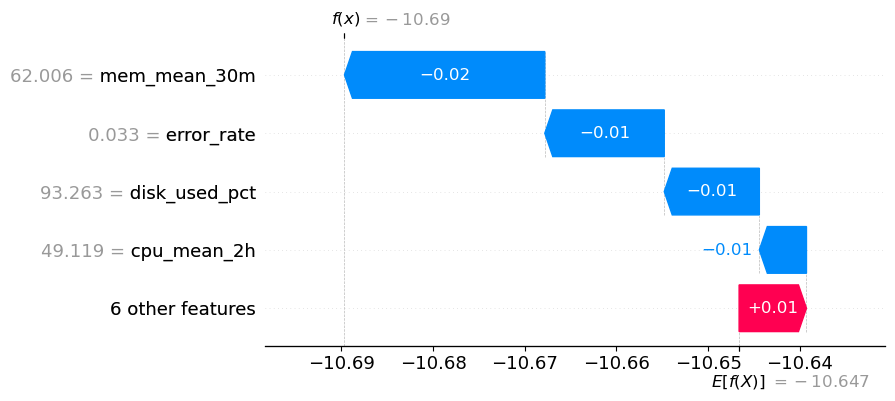

❌ SHAP not available for cpu_spike_in_next_24h
❌ SHAP not available for cpu_spike_in_next_7d

Explanation for mem_spike_in_next_2h


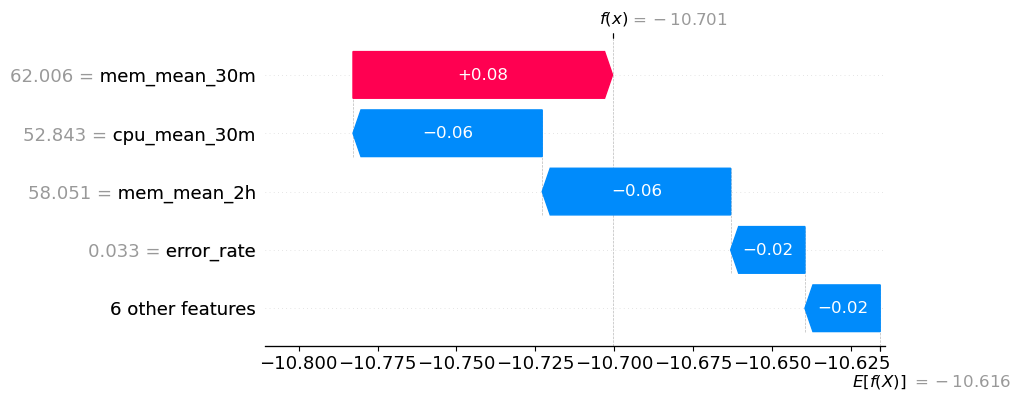

❌ SHAP not available for mem_spike_in_next_24h
❌ SHAP not available for mem_spike_in_next_7d

Explanation for storage_spike_in_next_2h


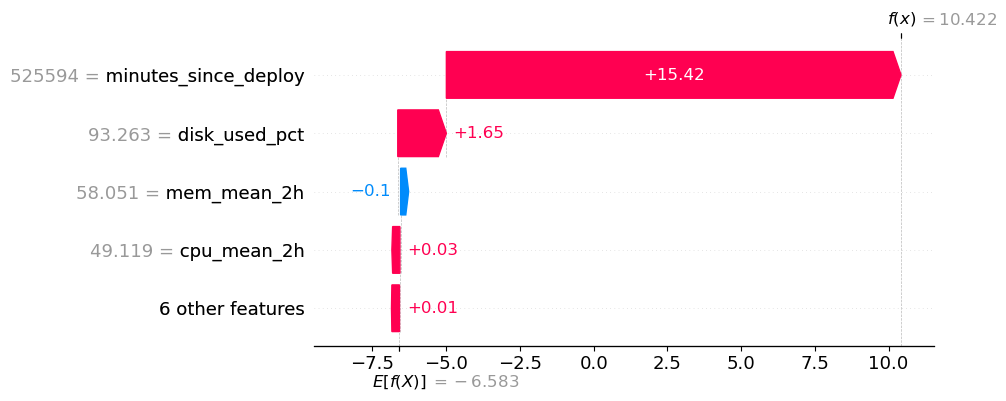


Explanation for storage_spike_in_next_24h


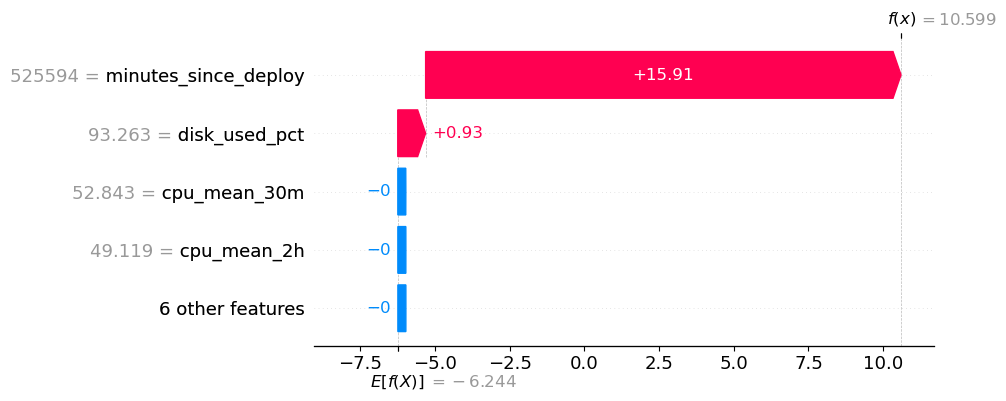


Explanation for storage_spike_in_next_7d


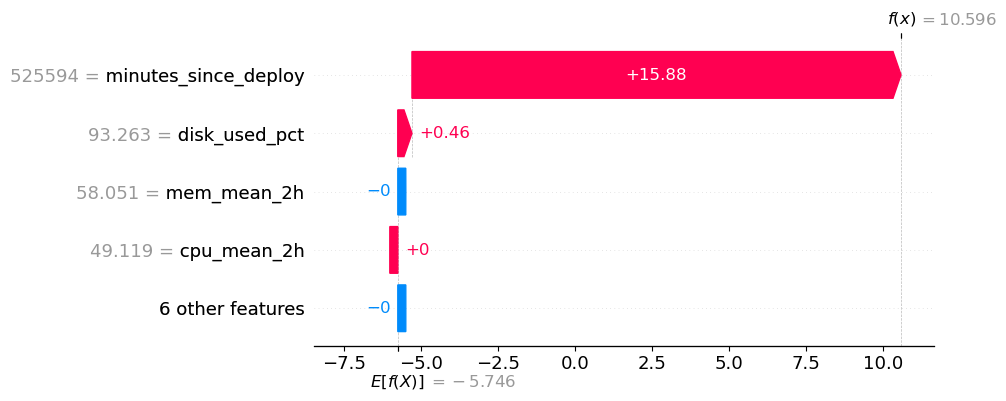


Explanation for incident_p1p2_in_next_2h


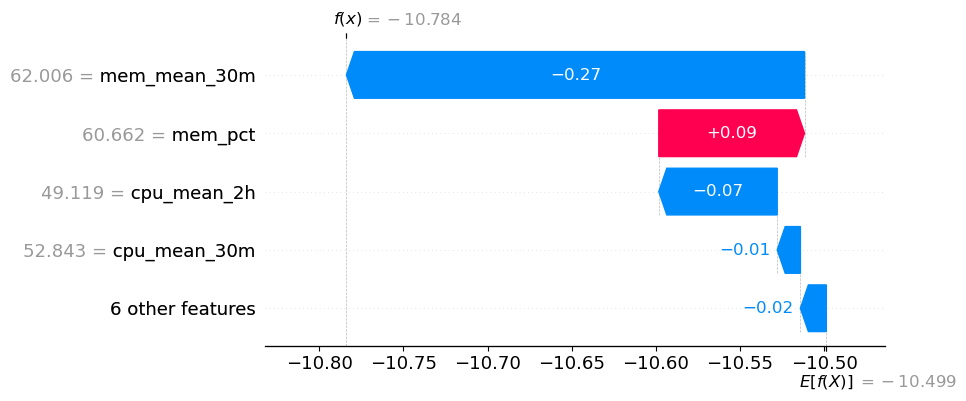


Explanation for incident_p1p2_in_next_24h


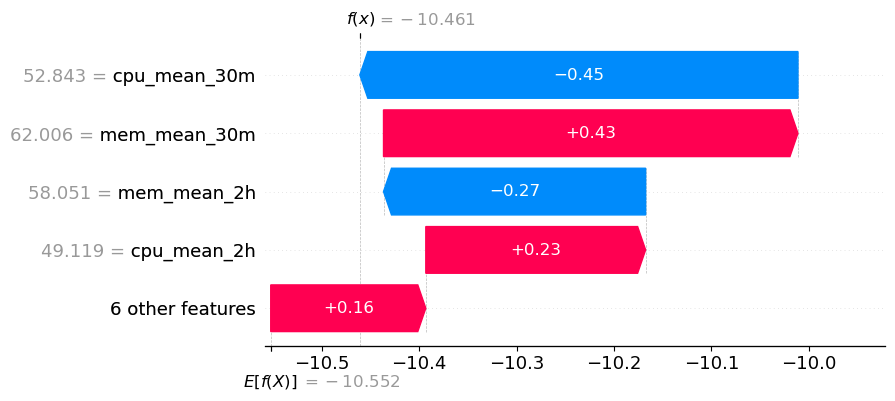


Explanation for incident_p1p2_in_next_7d


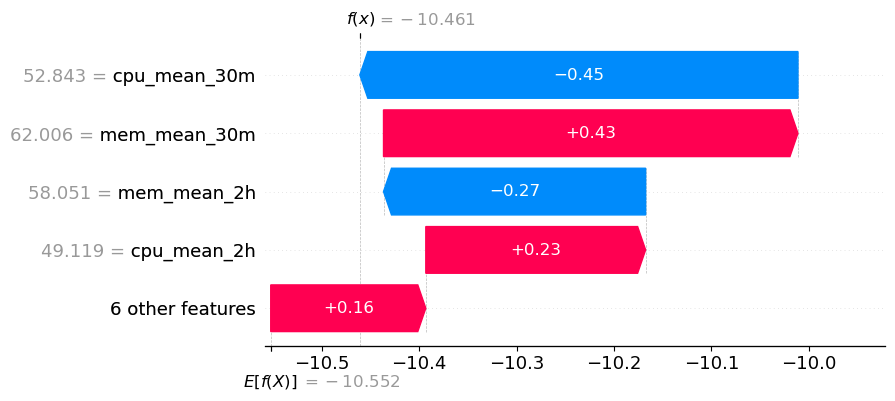

In [11]:
# --- SHAP Plots ---
# print("\nTop Feature Explanations")
# for label in labels:
#     if label in shap_explanations and shap_explanations[label] is not None:
#         print(f"\nExplanation for {label}")
#         try:
#             shap.plots.waterfall(shap_explanations[label][0], max_display=5)
#         except Exception as e:
#             print(f"Could not generate SHAP plot for {label}: {e}")
#     else:
#         print(f"\nExplanation for {label} not available (model was not trained)")

print("\nTop Feature Explanations")
for label in labels:
    if label in shap_explanations and shap_explanations[label] is not None:
        print(f"\nExplanation for {label}")
        try:
            shap.plots.waterfall(shap_explanations[label][0], max_display=5)
        except Exception as e:
            print(f"⚠️ Failed to plot SHAP for {label}: {e}")
    else:
        print(f"❌ SHAP not available for {label}")